In [1]:
#%pip install tensorflow

In [2]:
#%pip install --upgrade tensorflow-hub

In [3]:
#%pip install torch torchvision

In [4]:
#%pip install segment-geospatial groundingdino-py leafmap localtileserver

In [5]:
import os
import numpy as np
import cv2
import glob as glob
import json

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import warnings
import logging
import absl

from random import randint
from torchvision import transforms

from samgeo.text_sam import LangSAM

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 1.1 Display Sample Images

In [6]:
from PIL import Image 
 
jpg_folder = r'test_folder_4/jpg/'
# Use the os.listdir function to list the files in the folder 
image_files = os.listdir(jpg_folder)
 
map_folder = r'test_folder_4/png/'
# Use the os.listdir function to list the files in the folder 
map_files = os.listdir(map_folder)

inp_path_config_json = "rs19-config.json"
class_index = json.load(open(inp_path_config_json, 'r'))



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'test_folder_4/jpg/'

In [ ]:
len(image_files)

1700

In [ ]:
len(map_files)

1700

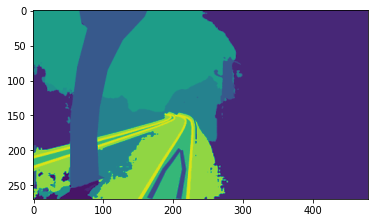

In [ ]:
for i,j in zip(image_files, map_files):
    image_path = (jpg_folder+i)
    label_path = (map_folder+j)

    im_jpg = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    im_id_map = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE) #get semantic label map

    plt.imshow(im_jpg)
    plt.imshow(im_id_map)

    break

In [ ]:
def config_to_rgb(inp_path_config_json, default_col = [255,255,255]):
    lut = []
    inp_json = json.load(open(inp_path_config_json, 'r'))
    for c in range(3): #for each color channel
        lut_c =[l["color"][c] for l in inp_json["labels"]]+[default_col[c]]*(256-len(inp_json["labels"]))
        lut.append(np.asarray(lut_c, dtype=np.uint8))
    return lut

lut_bgr = config_to_rgb(inp_path_config_json, default_col = [255,255,255])[::-1] 

def colorize_mask(mask, lut_bgr):
    label_map = mask #get semantic label map
    im_id_col = np.zeros((label_map.shape[0], label_map.shape[1], 3), np.uint8)
    
    for c in range(3):
        im_id_col[:,:,c] = lut_bgr[c][label_map] #apply color coding
    return im_id_col.astype(np.uint8) #blend all three data sources

im_vis = colorize_mask(im_id_map, lut_bgr)

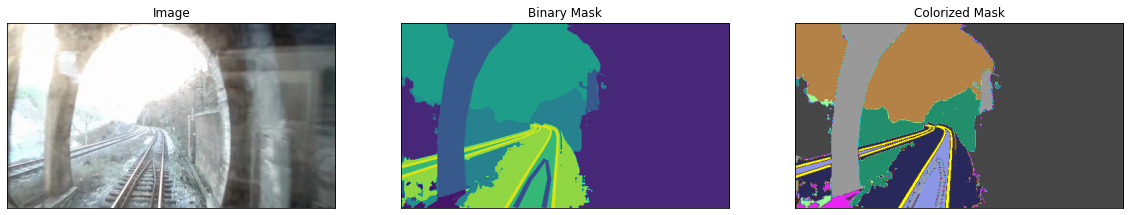

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(im_jpg)  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(im_id_map)  # Assuming the second image is grayscale
axes[1].set_title("Binary Mask")

# Plot the third image on the right
axes[2].imshow(im_vis)  
axes[2].set_title("Colorized Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side

## Model - Language Segment-Anything

Language Segment-Anything is an open-source project that combines the power of instance segmentation and text prompts to generate masks for specific objects in images. Built on the recently released Meta model, segment-anything, and the GroundingDINO detection model, it's an easy-to-use and effective tool for object detection and image segmentation.

In [ ]:
sam = LangSAM()
text_prompt = "vegetation"

final text_encoder_type: bert-base-uncased


In [39]:
sam.show_anns(
    cmap='Greens',
    add_boxes=False,
    alpha=0.5,
    title='Automatic Segmentation of Vegetation',
)

Please run predict() first.


In [101]:
box_threshold=0.24
text_threshold=0.3

In [71]:
iou_ls = []
im_jpg_ls = []
im_id_map_ls = []
total_mask_ls = []
ground_mask_veg_ls = []
sam_mask_veg_ls = []
counter = 0

for i,j in zip(image_files, map_files):
    image_path = (jpg_folder+i)
    label_path = (map_folder+j)

    im_jpg = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    im_id_map = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE) #get semantic label map

    image_pil = Image.open(image_path).convert("RGB")

    sam.predict(image_pil, text_prompt, box_threshold=box_threshold, text_threshold=text_threshold)

    masks = sam.masks

    total_mask = tf.zeros_like(masks[0], dtype=tf.uint8)

    for mask in masks:
        total_mask = tf.math.maximum(total_mask, mask)
    
    ground_mask_veg = np.where(np.isin(im_id_map, [8]), 1, 0)
    sam_mask_veg =  np.where(np.isin(total_mask, [1]), 1, 0)
    
    pixel_percentage_truly_predicted_veg = sam_mask_veg
    
    im = Image.fromarray(sam_mask_veg)
    # Define the transformation
    transform = transforms.ToTensor()

    # Apply the transformation to convert PIL Image to PyTorch Tensor
    tensor_img = transform(im)

    intersection = tf.reduce_sum(ground_mask_veg * im)
    union = tf.reduce_sum(tf.maximum(ground_mask_veg, tensor_img))
    
    iou = intersection / union
    iou_ls.append(iou)  # If you need the result as a NumPy array

    im_jpg_ls.append(im_jpg)
    im_id_map_ls.append(im_id_map)
    total_mask_ls.append(total_mask)
    ground_mask_veg_ls.append(ground_mask_veg)
    sam_mask_veg_ls.append(sam_mask_veg)

    counter += 1

    if counter==10:
        break




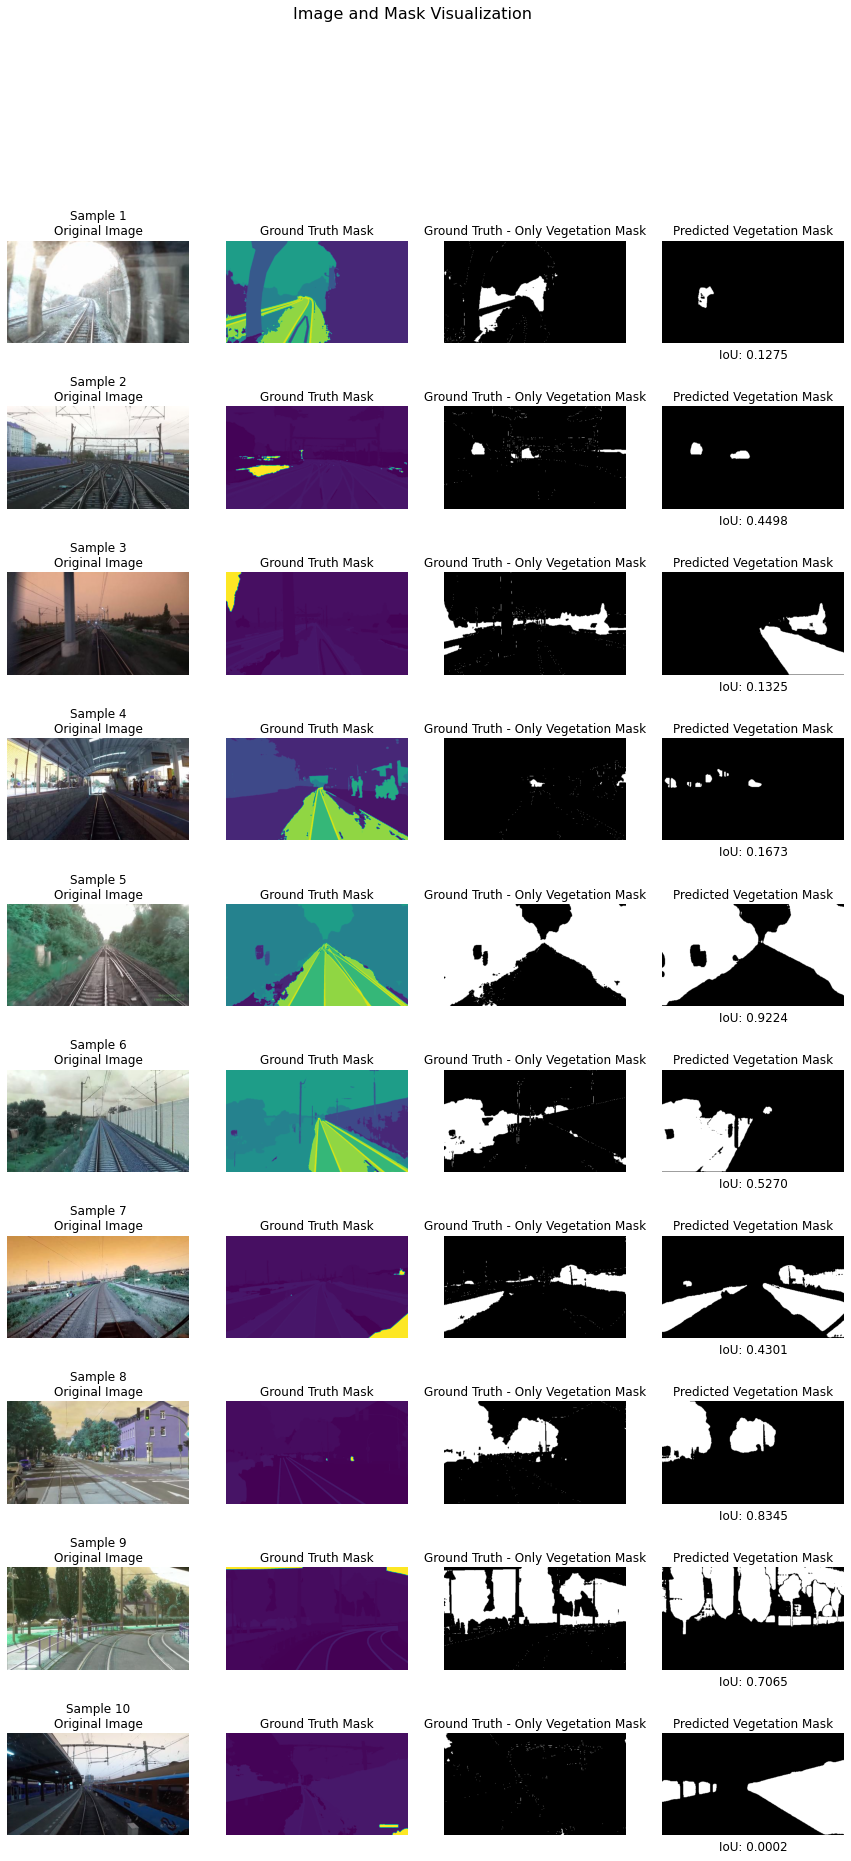

In [87]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import tensorflow as tf

def calculate_iou(ground_mask_veg, sam_mask_veg):
    intersection = np.logical_and(ground_mask_veg, sam_mask_veg)
    union = np.logical_or(ground_mask_veg, sam_mask_veg)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def visualize_pilots(im_jpg_ls, im_id_map_ls, ground_mask_veg_ls, sam_mask_veg_ls):
    num_samples = len(im_jpg_ls)

    # Set the number of columns for subplots
    num_cols = 4

    fig, axs = plt.subplots(num_samples, num_cols, figsize=(15, 3 * num_samples))
    fig.suptitle("Image and Mask Visualization", fontsize=16)

    for i in range(num_samples):
        axs[i, 0].imshow(im_jpg_ls[i])
        axs[i, 0].set_title(f"Sample {i + 1}\nOriginal Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(im_id_map_ls[i], cmap="viridis")
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(ground_mask_veg_ls[i], cmap="gray")
        axs[i, 2].set_title("Ground Truth - Only Vegetation Mask")
        axs[i, 2].axis("off")

        sam_mask_veg = sam_mask_veg_ls[i]
        axs[i, 3].imshow(sam_mask_veg, cmap="gray")
        axs[i, 3].set_title("Predicted Vegetation Mask")
        axs[i, 3].axis("off")

        iou = calculate_iou(ground_mask_veg_ls[i], sam_mask_veg)
        axs[i, 3].text(0.5, -0.15, f"IoU: {iou:.4f}", size=12, ha="center", transform=axs[i, 3].transAxes)

    plt.show()

# Call the function with your lists
visualize_pilots(im_jpg_ls, im_id_map_ls, ground_mask_veg_ls, sam_mask_veg_ls)


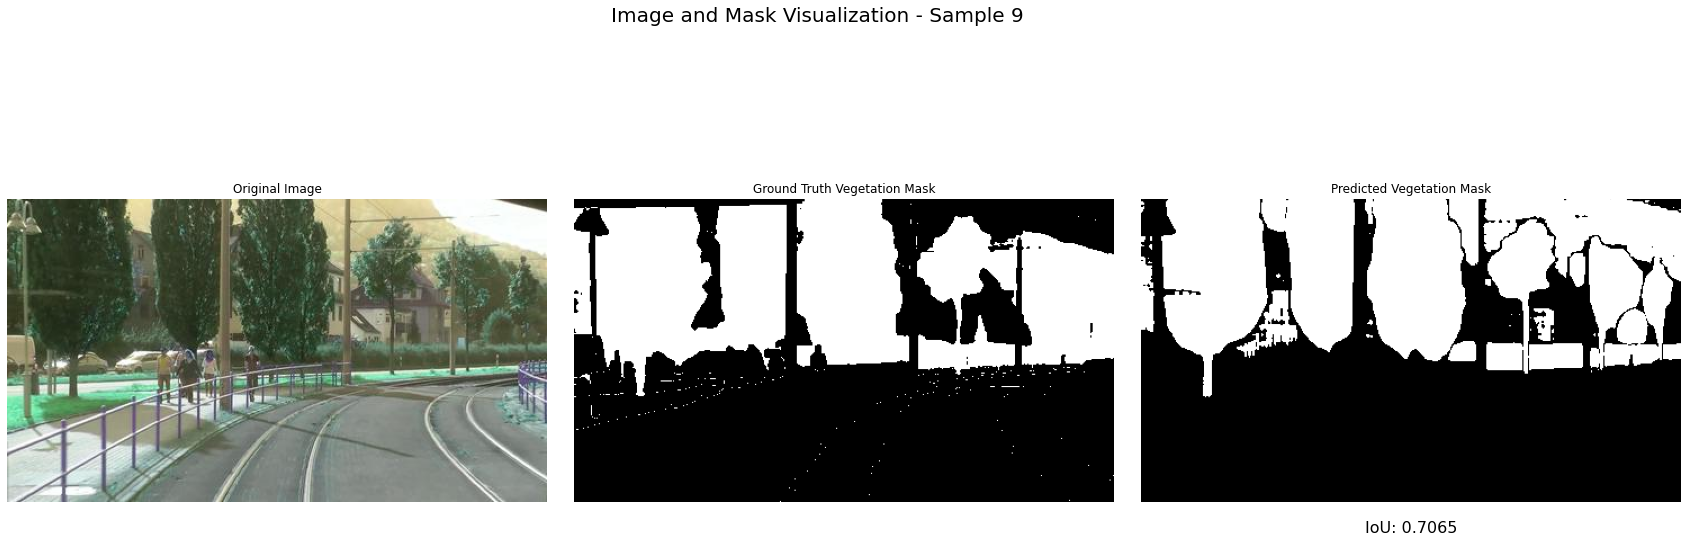

In [100]:
def calculate_iou(ground_mask_veg, sam_mask_veg):
    intersection = np.logical_and(ground_mask_veg, sam_mask_veg)
    union = np.logical_or(ground_mask_veg, sam_mask_veg)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def visualize_sample(im_jpg, ground_mask_veg, sam_mask_veg):
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    fig.subplots_adjust(wspace=0.05)  # Adjust the horizontal space between subplots
    fig.suptitle("Image and Mask Visualization - Sample 9", fontsize=20)

    axs[0].imshow(im_jpg)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(ground_mask_veg, cmap="gray")
    axs[1].set_title("Ground Truth Vegetation Mask")
    axs[1].axis("off")

    axs[2].imshow(sam_mask_veg, cmap="gray")
    axs[2].set_title("Predicted Vegetation Mask")
    axs[2].axis("off")

    iou = calculate_iou(ground_mask_veg, sam_mask_veg)
    axs[2].text(0.5, -0.1, f"IoU: {iou:.4f}", size=16, ha="center", transform=axs[2].transAxes)

    plt.show()

# Call the function with your lists for sample 9
sample_index = 8  # Sample 9, as indexing starts from 0
visualize_sample(im_jpg_ls[sample_index], ground_mask_veg_ls[sample_index], sam_mask_veg_ls[sample_index])


In [70]:
np.mean(iou_ls)

0.4297794516300873

In [56]:
intersection

<tf.Tensor: shape=(), dtype=int32, numpy=1227>

In [57]:
union

<tf.Tensor: shape=(), dtype=int32, numpy=9622>

In [64]:
sam_mask_veg# Get unique values and their counts
unique_values, counts = np.unique(sam_mask_veg, return_counts=True)

# Print unique values
print("Unique Values:", unique_values)

# Print counts
print("Counts:", counts)

Unique Values: [0 1]
Counts: [128335   1265]


In [65]:
sam_mask_veg# Get unique values and their counts
unique_values, counts = np.unique(ground_mask_veg, return_counts=True)

# Print unique values
print("Unique Values:", unique_values)

# Print counts
print("Counts:", counts)

Unique Values: [0 1]
Counts: [120016   9584]


In [ ]:
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    num_rows = (num_masks + 1) // 4 + 1
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, 5 * num_rows))

    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    for i, mask_np in enumerate(masks):
        row = (i + 1) // 4
        col = (i + 1) % 4
        axes[row, col].imshow(mask_np, cmap='gray')
        axes[row, col].set_title(f"Mask {i+1}")
        axes[row, col].axis('off')

    # Hide any remaining empty subplots
    for i in range((num_rows * 4) - num_masks):
        row = (num_masks + i) // 4
        col = (num_masks + i) % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# display_image_with_masks(original_image, [mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8])



In [ ]:
def combine_masks(masks):
    total_mask = tf.zeros_like(masks[0], dtype=tf.uint8)

    for mask in masks:
        total_mask = tf.math.maximum(total_mask, mask)

    return total_mask

def display_image_with_masks_and_blend(image, masks):
    total_mask = combine_masks(masks)

    # Expand dimensions of the mask to match the number of channels in the image
    total_mask_expanded = tf.expand_dims(total_mask, axis=-1)

    # Create a blended image by applying the total mask
    blended_image = image * (1 - total_mask_expanded) + total_mask_expanded * 255

    # Convert the blended image to uint8
    blended_image = tf.cast(blended_image, tf.uint8)

    num_masks = len(masks)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(total_mask, cmap='gray')
    axes[1].set_title("Total Mask")
    axes[1].axis('off')

    axes[2].imshow(blended_image.numpy())
    axes[2].set_title("Blended Image")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming original_image is your original image tensor and masks_list is a list of individual masks
# display_image_with_masks_and_blend(original_image, masks_list)


# Example usage:
# Assuming original_image is your original image and masks_list is a list of individual masks
display_image_with_masks_and_blend(image_pil, sam.masks)


## Predicted Mask vs Ground Truth Mask

In [ ]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    
    iou = intersection / union
    return iou.numpy()  # If you need the result as a NumPy array

# Example usage:
# Assuming y_true and y_pred are binary masks with values 0 and 1
# iou_value = calculate_iou(y_true, y_pred)


In [ ]:
interested_array = np.where(np.isin(im_id_map, [8]), 1, 0)
sam_mask_veg = combine_masks(sam.masks)
sam_mask_veg =  np.where(np.isin(sam_mask_veg, [1]), 1, 0)

# Assuming total_mask is a TensorFlow tensor

unique_values, counts = np.unique(sam_mask_veg, return_counts=True)

for value, frequency in zip(unique_values, counts):
    print(f"Value: {value}, Total Frequency: {frequency}")

In [ ]:
iou_value = calculate_iou(interested_array, sam_mask_veg)


In [ ]:
fig = plt.figure(figsize=(20, 15))
# Display the original image.
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(im_jpg)
ax1.title.set_text('Original Image')
plt.axis('off')

# Display the predicted color segmentation mask. 
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Predicted Mask for Vegetation')
ax2.imshow(sam_mask_veg)
plt.axis('off')

# Display the predicted color segmentation mask overlayed on the original image.
ax4 = fig.add_subplot(1,3,3)
ax4.set_title('Ground Truth for Vegetation')
ax4.imshow(interested_array)
plt.axis('off')

plt.show()
